       Unnamed: 0  Latitude  Longitude  Average temperature per year  \
count    38472.00  38472.00   38472.00                      38472.00   
mean     19235.50     23.74      20.21                         17.72   
std      11106.05     26.06      61.07                          8.13   
min          0.00    -40.90    -106.35                         -2.00   
25%       9617.75      8.62      -3.44                         11.00   
50%      19235.50     27.51      21.82                         20.00   
75%      28853.25     45.94      47.48                         25.00   
max      38471.00     64.96     179.41                         29.00   

       Hospital beds per 1000 people  Medical doctors per 1000 people  \
count                       38472.00                         38472.00   
mean                            3.17                             2.09   
std                             2.56                             1.52   
min                             0.20                       

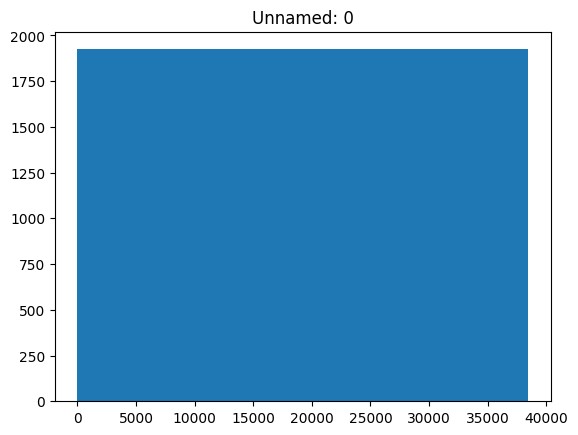

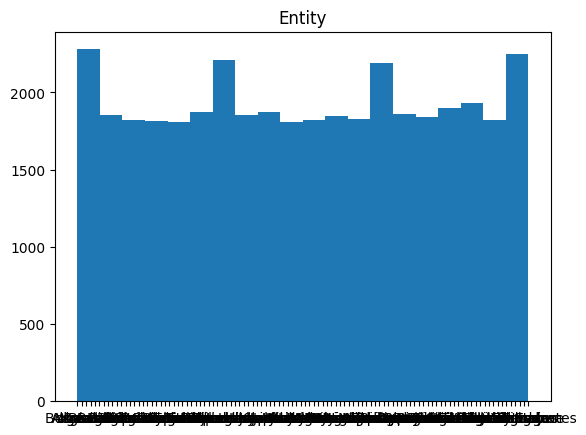

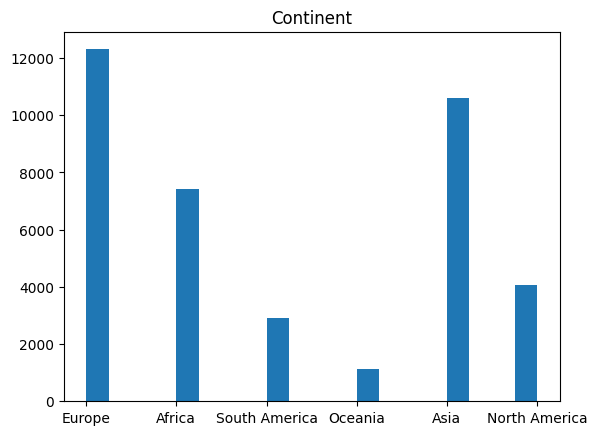

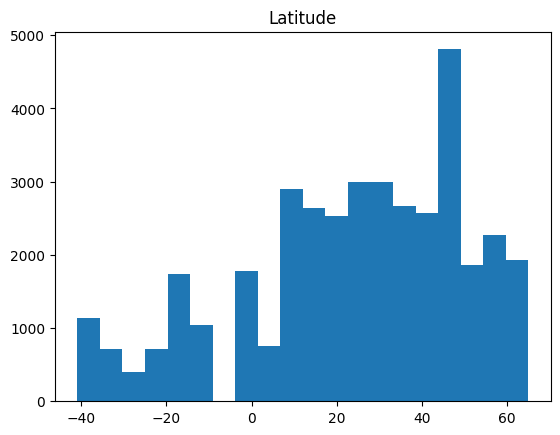

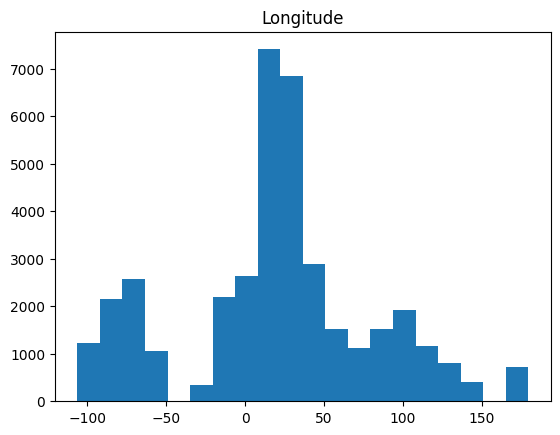

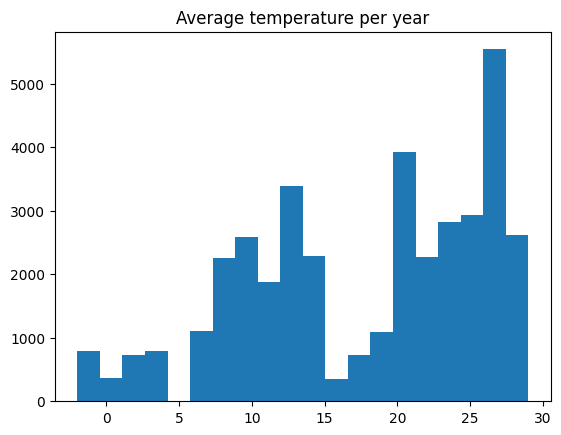

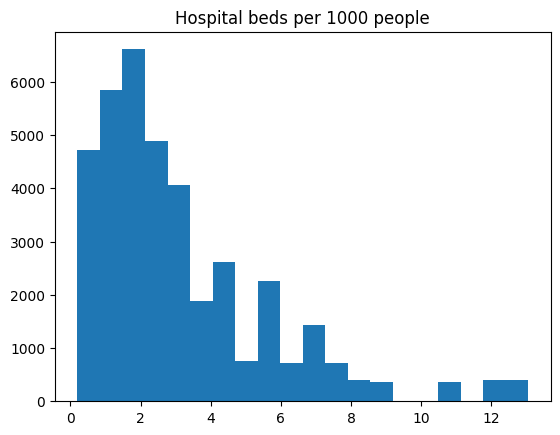

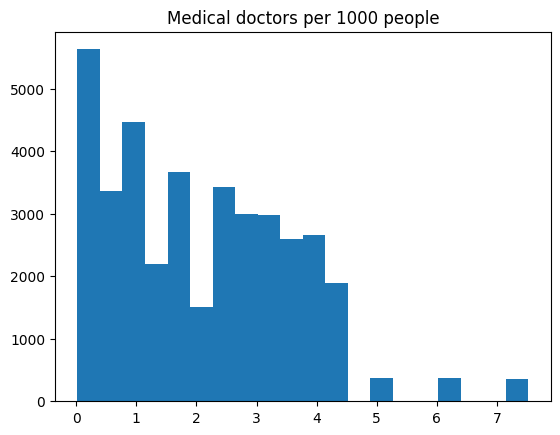

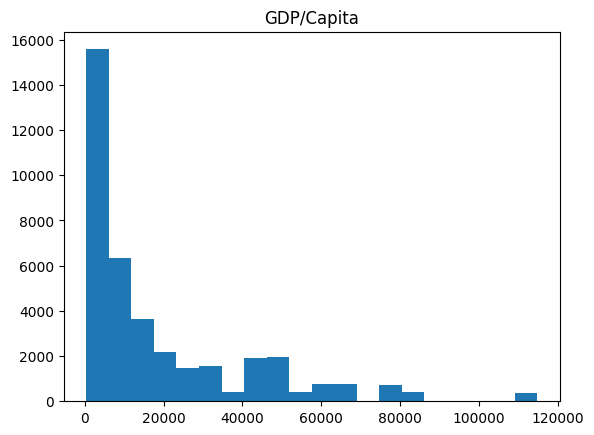

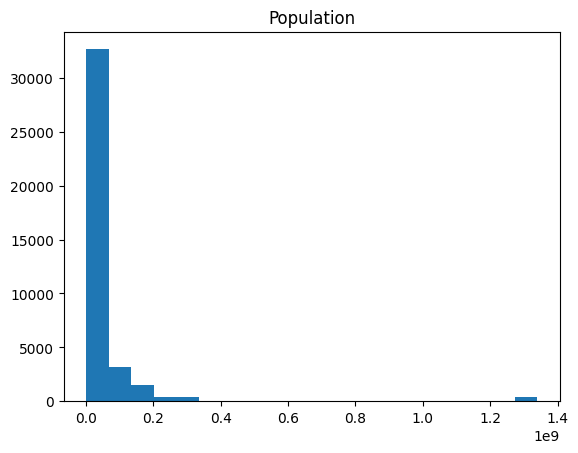

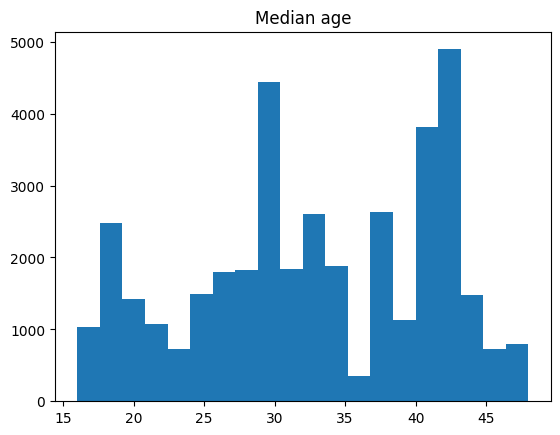

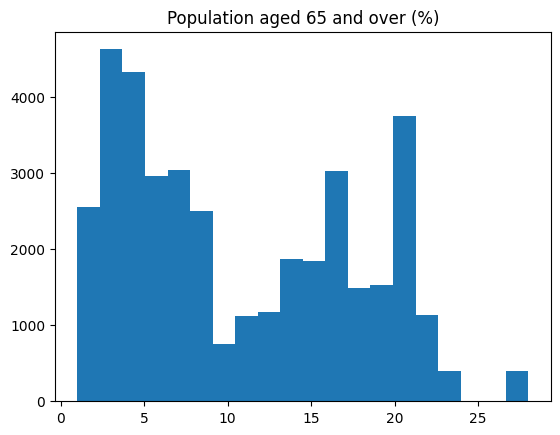

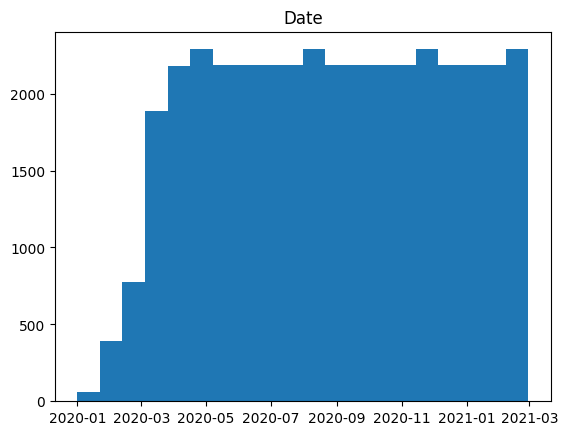

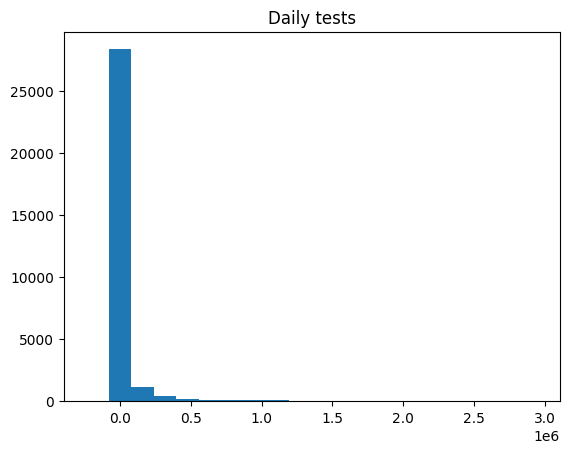

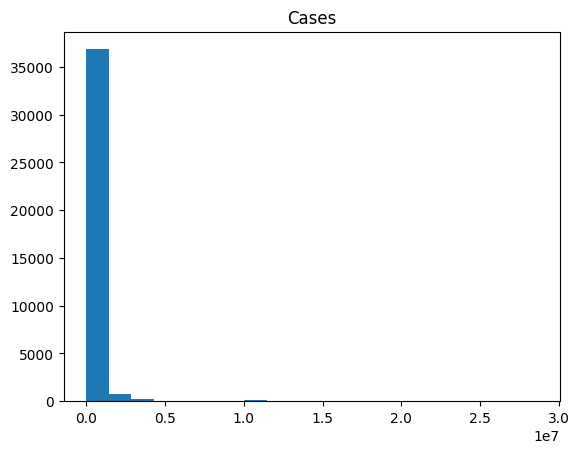

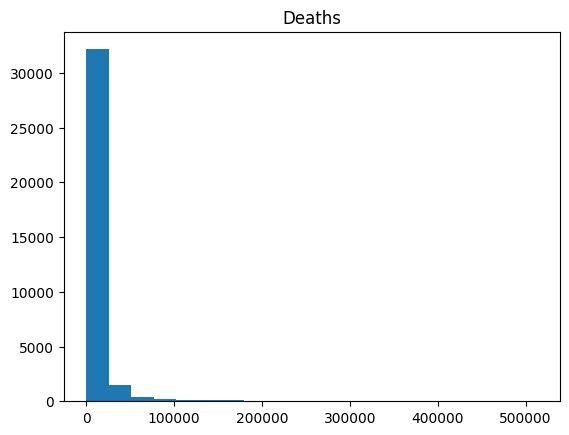

   Unnamed: 0   Entity Continent  Latitude  Longitude  \
0           0  Albania    Europe     41.15      20.17   

   Average temperature per year  Hospital beds per 1000 people  \
0                            14                           2.89   

   Medical doctors per 1000 people  GDP/Capita  Population  Median age  \
0                             1.29      5353.2     2873457          38   

   Population aged 65 and over (%)       Date  Daily tests  Cases  Deaths  
0                               14 2020-02-25          8.0    NaN     NaN  


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
# read the CSV file into a pandas dataframe
df = pd.read_csv('data.csv')

# save the updated dataframe as a CSV file
df.to_csv(('data.csv'), index=True)

df = pd.read_csv('data.csv')
df["Date"] = pd.to_datetime(df["Date"])
print(df.describe().round(2))
for col in df.columns:
    plt.hist(df[col], bins=20)
    plt.title(col)
    plt.show()
print(df.head(1))

                                 Unnamed: 0  Latitude  Longitude  Average temperature per year  Hospital beds per 1000 people  Medical doctors per 1000 people  GDP/Capita  Population  Median age  Population aged 65 and over (%)  Daily tests     Cases    Deaths
Unnamed: 0                         1.000000 -0.062807   0.131874                      0.069906                      -0.052053                        -0.157499    0.005762    0.016138   -0.113642                        -0.131661     0.132245  0.088981  0.107605
Latitude                          -0.062807  1.000000   0.022212                     -0.567321                       0.455026                         0.516162    0.415517   -0.021433    0.604999                         0.542527     0.111004  0.046270  0.060524
Longitude                          0.131874  0.022212   1.000000                      0.007620                       0.203363                        -0.094238   -0.040357    0.135531    0.015003                       

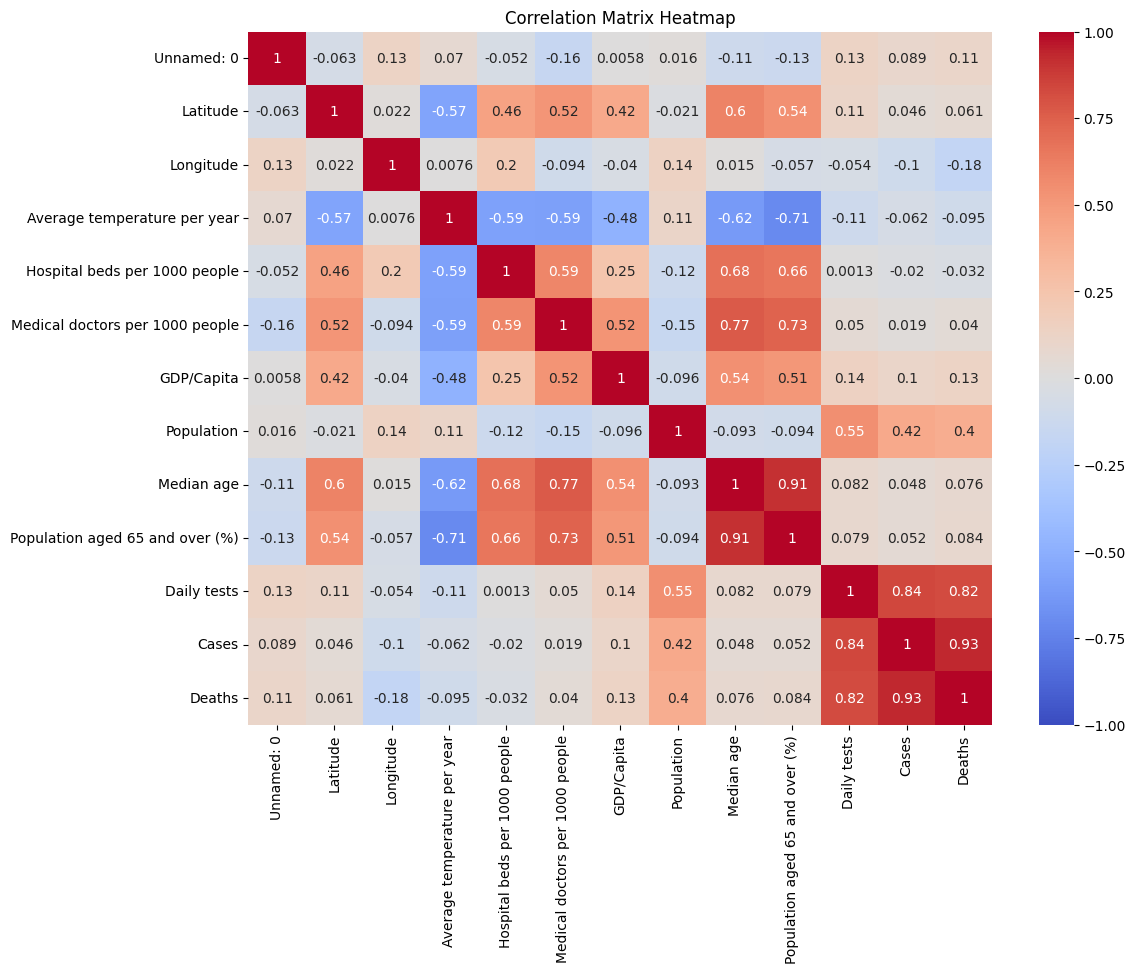

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix.to_string())
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


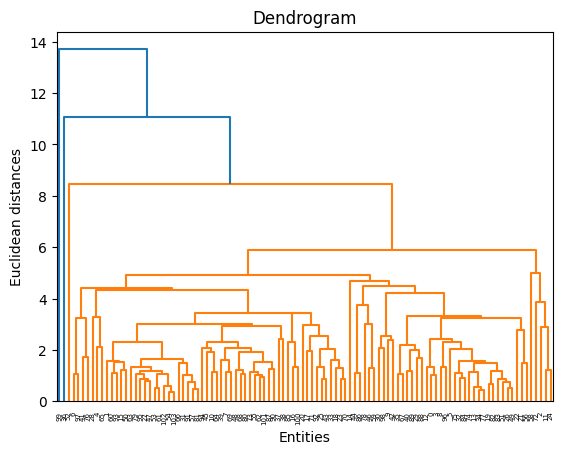

In [27]:

import numpy as np
from scipy.stats import boxcox, yeojohnson
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

df = pd.read_csv('data.csv')
df["Date"] = pd.to_datetime(df["Date"])

df = df.groupby('Entity',group_keys=False).apply(lambda x: x.fillna(method='ffill'))
df = df.groupby('Entity',group_keys=False).apply(lambda x: x.fillna(method='bfill'))
df = df[df.Cases > 0]


df.drop_duplicates(inplace=True)

df.dropna(inplace=True)

# Group the data by entity
grouped_data = df.groupby('Entity')

# Compute the new cases and add a new column to the DataFrame
df['New Cases'] = grouped_data['Cases'].diff()
#df['New Deaths'] = grouped_data['Deaths'].diff()
df.fillna(value=0, inplace=True)

df['Positive Ratio'] = (df['New Cases'] / df['Daily tests']) * 100

df['Death Ratio'] = (df['Deaths'] / df['Cases']) * 100

df["Tested ratio"]=(df['Daily tests'] / df['Population']) * 100

# Group the data by entity
grouped_data = df.groupby('Entity')

# Compute the average positive ratio, death ratio, and tested ratio,
# and keep the latest values for all other fields
result_data = grouped_data.agg({
    'Continent': 'last',
    'Latitude': 'last',
    'Longitude': 'last',
    'Average temperature per year': 'mean',
    'Hospital beds per 1000 people': 'mean',
    'GDP/Capita': 'last',
    'Population': 'last',
    'Median age': 'last',
    'Date': 'max',
    'Cases': 'last',
    'Deaths': 'last',
    'Positive Ratio': 'median',
    'Death Ratio': 'median',
    'Tested ratio': 'median'
})

#print(result_data[result_data.index.str.startswith('India')].to_string())
# Get the unique values in the continent column
continent_values = result_data['Continent'].unique()

# Create a dictionary that maps each unique value to a unique number
continent_map = {continent_values[i]: i+1 for i in range(len(continent_values))}

# Replace the unique values with the corresponding numbers
result_data['Continent'] = result_data['Continent'].replace(continent_map)

features=['Continent', 'Latitude', 'Longitude', 'Average temperature per year',
       'Hospital beds per 1000 people', 'GDP/Capita', 'Population',
       'Median age','Cases', 'Deaths', 'Positive Ratio',
       'Death Ratio', 'Tested ratio']

result_data[features] = result_data[features].astype(float)

scaler = StandardScaler()

normalized_data = result_data.copy()
normalized_data[features] = scaler.fit_transform(result_data[features])
scaled_features=normalized_data[features]

# n_clusters=10
# # Cluster the data using the best k value
# kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init="auto")
# kmeans.fit(scaled_features)
# scaled_features['Cluster'] = kmeans.labels_
# result_data['Cluster'] = kmeans.labels_

# # Plot the clusters
# labels = kmeans.labels_
# scatter = plt.scatter(scaled_features['Death Ratio'], scaled_features['GDP/Capita'], c=labels)

# plt.title('Clusters')
# plt.xlabel("Death Ratio")
# plt.ylabel("GDP/Capita")

# handles, labels = scatter.legend_elements()
# legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
# legend = plt.legend(handles, legend_labels, loc='upper right', title='Clusters')

# cluster_groups = result_data.groupby('Cluster')
# cluster_entity_names = cluster_groups.apply(lambda x: ', '.join(x.index))
# cluster_entity_names_df = pd.DataFrame({'Entity Names': cluster_entity_names})
# print(cluster_entity_names_df.to_string())



# Create a dendrogram to help determine the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(scaled_features, method='average'))
plt.title('Dendrogram')
plt.xlabel('Entities')
plt.ylabel('Euclidean distances')
plt.show()

distance_threshold = 7.0
cluster = AgglomerativeClustering(n_clusters=None, metric='euclidean', linkage='ward', distance_threshold=distance_threshold)
cluster.fit_predict(scaled_features)
scaled_features['Cluster'] = cluster.labels_
result_data['Cluster'] = cluster.labels_



                                                                                                                                                                                                              Entity Names
Cluster                                                                                                                                                                                                                   
0                                                                                  Albania, Algeria, Argentina, Armenia, Bosnia and Herzegovina, Chile, Colombia, Libya, Morocco, Paraguay, South Africa, Tunisia, Uruguay
1                                                                                                                                                        Bahrain, Cyprus, Denmark, Luxembourg, Malta, United Arab Emirates
2                                                                                                                           

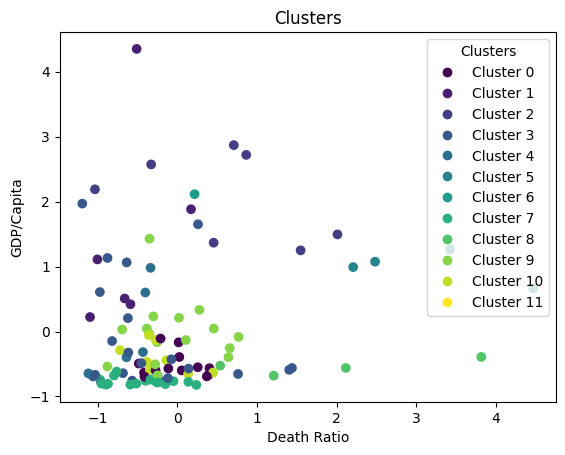

In [28]:

# Plot the clusters
labels = cluster.labels_
scatter = plt.scatter(scaled_features['Death Ratio'], scaled_features['GDP/Capita'], c=labels)

plt.title('Clusters')
plt.xlabel("Death Ratio")
plt.ylabel("GDP/Capita")

handles, labels = scatter.legend_elements()
legend_labels = [f'Cluster {i}' for i in range(15)]
legend = plt.legend(handles, legend_labels, loc='upper right', title='Clusters')

cluster_groups = result_data.groupby('Cluster')
cluster_entity_names = cluster_groups.apply(lambda x: ', '.join(x.index))
cluster_entity_names_df = pd.DataFrame({'Entity Names': cluster_entity_names})
print(cluster_entity_names_df.to_string())

# Compute cluster statistics
cluster_stats = scaled_features.groupby('Cluster').agg({
    'Continent': lambda x: x.mode().iloc[0],
    'Latitude': ['mean', 'std'],
    'Longitude': ['mean', 'std'],
    'Average temperature per year': ['mean', 'std'],
    'Hospital beds per 1000 people': ['mean', 'std'],
    'GDP/Capita': ['mean', 'std'],
    'Population': ['mean', 'std'],
    'Median age': ['mean', 'std'],
    'Cases': ['mean', 'std'],
    'Deaths': ['mean', 'std'],
    'Positive Ratio': ['mean', 'std'],
    'Death Ratio': ['mean', 'std'],
    'Tested ratio': ['mean', 'std']
})

# Print cluster statistics
for cluster_id in range(len(cluster_stats)):
    print(f"\nCluster {cluster_id+1} statistics:")
    print(f"Continent: {cluster_stats.loc[cluster_id, ('Continent', '<lambda>')]}")
    print(f"Latitude: mean = {cluster_stats.loc[cluster_id, ('Latitude', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Latitude', 'std')]:.2f}")
    print(f"Longitude: mean = {cluster_stats.loc[cluster_id, ('Longitude', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Longitude', 'std')]:.2f}")
    print(f"Average temperature per year: mean = {cluster_stats.loc[cluster_id, ('Average temperature per year', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Average temperature per year', 'std')]:.2f}")
    print(f"Hospital beds per 1000 people: mean = {cluster_stats.loc[cluster_id, ('Hospital beds per 1000 people', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Hospital beds per 1000 people', 'std')]:.2f}")
    print(f"GDP/Capita: mean = {cluster_stats.loc[cluster_id, ('GDP/Capita', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('GDP/Capita', 'std')]:.2f}")
    print(f"Population: mean = {cluster_stats.loc[cluster_id, ('Population', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Population', 'std')]:.2f}")
    print(f"Median age: mean = {cluster_stats.loc[cluster_id, ('Median age', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Median age', 'std')]:.2f}")
    print(f"Cases: mean = {cluster_stats.loc[cluster_id, ('Cases', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Cases', 'std')]:.2f}")
    print(f"Deaths: mean = {cluster_stats.loc[cluster_id, ('Deaths', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Deaths', 'std')]:.2f}")#na kanononikopiithi me to population
    print(f"Positive Ratio: mean = {cluster_stats.loc[cluster_id, ('Positive Ratio', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Positive Ratio','std')]:.2f}")
    print(f"Death Ratio: mean = {cluster_stats.loc[cluster_id, ('Death Ratio', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Death Ratio', 'std')]:.2f}")
    print(f"Tested ratio: mean = {cluster_stats.loc[cluster_id, ('Tested ratio', 'mean')]:.2f}, std = {cluster_stats.loc[cluster_id, ('Tested ratio', 'std')]:.2f}")



In [29]:
import numpy as np
import pandas as pd                
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df = pd.read_csv('data.csv')

greece_df = df.loc[df['Entity'] == 'Greece', ['Date', 'Cases', 'Deaths', 'Daily tests']].copy()
greece_df.dropna(inplace=True)
greece_df["Date"] = pd.to_datetime(greece_df["Date"])
greece_df['New Cases'] = greece_df['Cases'].diff()
greece_df = greece_df.fillna(0)
greece_df['Positive Ratio'] = (greece_df['New Cases'] / greece_df['Daily tests']) * 100
greece_df['Death Ratio'] = (greece_df['Deaths'] / greece_df['Cases']) * 100
greece_df["Tested ratio"] = (greece_df['Daily tests'] / 10760421.0) * 100

# create a MinMax scaler object for all columns
scaler = StandardScaler()

# select all columns to normalize
columns_to_normalize = ['Daily tests','Cases', 'Deaths','New Cases','Positive Ratio','Death Ratio',"Tested ratio"]

# fit and transform all columns with the scaler object
greece_df[columns_to_normalize] = scaler.fit_transform(greece_df[columns_to_normalize])
print(greece_df.head(20).to_string())

greece_df.to_csv('preprocessed_numeric_data.csv', index=False)


            Date     Cases    Deaths  Daily tests  New Cases  Positive Ratio  Death Ratio  Tested ratio
11818 2020-03-13 -0.840488 -0.763711    -1.034027  -0.709735       -0.693418    -2.206651     -1.034027
11819 2020-03-14 -0.839890 -0.762812    -1.021556  -0.666010        0.252993    -1.652123     -1.021556
11820 2020-03-15 -0.838267 -0.762362    -1.028484  -0.591219        2.299400    -1.727512     -1.028484
11821 2020-03-16 -0.838267 -0.762362    -1.047884  -0.709735       -0.693418    -1.727512     -1.047884
11826 2020-03-21 -0.835133 -0.758316    -1.024466  -0.480757        4.579142    -0.853464     -1.024466
11827 2020-03-22 -0.833652 -0.757417    -1.057862  -0.601575        8.617865    -0.887871     -1.057862
11828 2020-03-23 -0.832534 -0.756518    -1.025851  -0.628039        1.246717    -0.858231     -1.025851
11829 2020-03-24 -0.831778 -0.755169    -1.040471  -0.654504        1.266364    -0.685618     -1.040471
11830 2020-03-25 -0.830550 -0.754270    -0.971392  -0.619985    